# Introduction to `fastplotlib`

This notebook goes through basic components of the `fastplotlib` API including images, image updates, and `ImageWidget`.

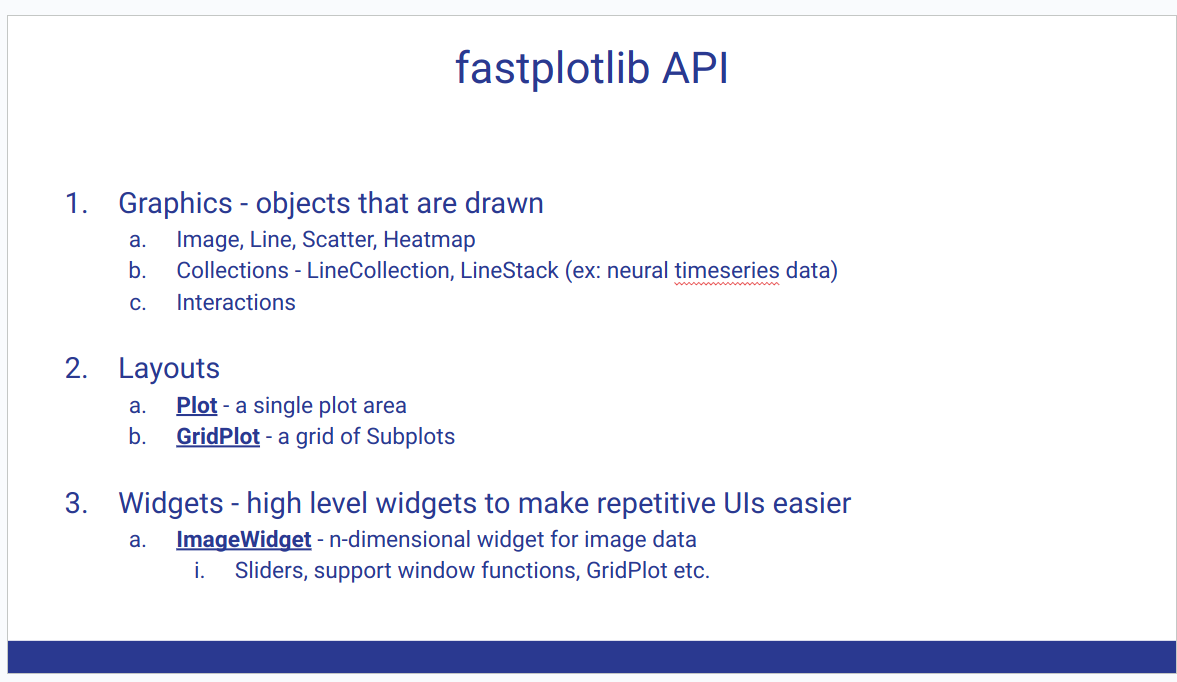

In [1]:
import fastplotlib as fpl
from ipywidgets import VBox, HBox, IntSlider
import numpy as np
from sidecar import Sidecar

### Simple image

In [2]:
# create a `Plot` instance
plot = fpl.Plot()

# make some random 2D image data
data = np.random.rand(512, 512)

# plot the image data
image_graphic = plot.add_image(data=data, name="random-image")

# display plot in side car
sc = Sidecar(title="simple image")

with sc:
    # show the plot
    display(plot.show())

RFBOutputContext()

/home/clewis7/repos/fastplotlib/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


### Use the handle on the bottom right corner of the _canvas_ to resize it. You can also pan and zoom using your mouse!

Changing graphic "features"

In [3]:
image_graphic.cmap = "viridis"

In [4]:
image_graphic.data = 0

In [5]:
image_graphic.data[::15, :] = 1
image_graphic.data[:, ::15] = 1

In [6]:
image_graphic.data = np.random.rand(512, 512)

### Plots are indexable and give you their graphics by name

In [7]:
plot.graphics

(<weakproxy at 0x7f3993f3f560 to ImageGraphic at 0x7f3993f646d0>,)

In [8]:
plot["random-image"]

<weakproxy at 0x7f3993f3f560 to ImageGraphic at 0x7f3993f646d0>

#### The `Graphic` instance is also returned when you call `plot.add_<graphic_type>`.

In [9]:
image_graphic

<weakproxy at 0x7f3993f3f560 to ImageGraphic at 0x7f3993f646d0>

In [10]:
image_graphic == plot["random-image"]

True

In [11]:
# close sidecar
sc.close()

### Image updates

This examples show how you can define animation functions that run on every render cycle.

In [12]:
# create another `Plot` instance
plot_v = fpl.Plot()

plot.canvas.max_buffered_frames = 1

# make some random data again
data = np.random.rand(512, 512)

# plot the data
plot_v.add_image(data=data, name="random-image")

# a function to update the image_graphic
# a plot will pass its plot instance to the animation function as an arugment
def update_data(plot_instance):
    new_data = np.random.rand(512, 512)
    plot_instance["random-image"].data = new_data

#add this as an animation function
plot_v.add_animations(update_data)

# sidecar to display plot
sc = Sidecar(title="image updates")

with sc:
    # show the plot
    display(plot_v.show())

RFBOutputContext()

### We can share controllers across plots

This example creates a new plot, but it synchronizes the pan-zoom controller

In [13]:
plot_sync = fpl.Plot(controller=plot_v.controller)

data = np.random.rand(512, 512)

image_graphic_instance = plot_sync.add_image(data=data, cmap="viridis")

# you will need to define a new animation function for this graphic
def update_data_2():
    new_data = np.random.rand(512, 512)
    # alternatively, you can use the stored reference to the graphic as well instead of indexing the Plot
    image_graphic_instance.data = new_data

plot_sync.add_animations(update_data_2)

plot_sync.show()

RFBOutputContext()

#### Keeping a reference to the Graphic instance, as shown above `image_graphic_instance`, is useful if you're creating something where you need flexibility in the naming of the graphics

In [14]:
sc.close()

### You can also use `ipywidgets.VBox` and `HBox` to stack plots.

In [15]:
VBox([plot_v.show(), plot_sync.show()])

In [16]:
HBox([plot_v.show(), plot_sync.show()])

In [17]:
# close plots
plot_v.close()
plot_sync.close()
plot.close()

# Sliders to scroll through image data

We often already have large image arrays (whether in RAM or through lazy loading), and want to view 2D frames across one or more dimensions. There is an `ImageWidget` that should really be used for this, but this example just shows how you can use `ipywidgets` to change data or any **`GraphicFeature`**

In [1]:
# use cockatoo videos

## Plot and scroll through the first dimension with a slider

In [18]:
plot_movie = fpl.Plot()

# plot the first frame to initialize
movie_graphic = plot_movie.add_image(movie[0], vmin=0, vmax=movie.max(), cmap="gnuplot2")

# make a slider
slider = IntSlider(min=0, max=movie.shape[0] - 1, step=1, value=0)

# function to update movie_graphic
def update_movie(change):    
    index = change["new"]
    movie_graphic.data = movie[index]
    
slider.observe(update_movie, "value")
    
# Use an ipywidgets VBox to show the plot and slider
VBox([plot_movie.show(), slider])

RFBOutputContext()

NameError: name 'movie' is not defined

#### Note that the use of globals in the `update_movie()` here can get messy, this is not recommended and  you should create a class to properly handle combining widgets like this. _However_ if you want slider widgets for imaging data the recommended way to do this is by using the `ImageWidget`.

## Single image sequence `ImageWidget` using zebrafish data

In [2]:
# use zebrafish data

In [13]:
iw = fpl.ImageWidget(
    data=a,
    vmin_vmax_sliders=True,
    cmap="viridis"
)

RFBOutputContext()

In [14]:
sc = Sidecar()

with sc:
    display(iw.show())

### can dynamically change features

In [15]:
iw.gridplot[0, 0].graphics[0].cmap = "gnuplot2"

### Play with setting different window functions

These can also be given as kwargs to `ImageWidget` during instantiation

In [16]:
# must be in the form of {dim: (func, window_size)}
iw.window_funcs = {"t": (np.mean, 13)}

In [17]:
# change the winow size
iw.window_funcs["t"].window_size = 23

In [18]:
# change the function
iw.window_funcs["t"].func = np.max

In [19]:
# or set it again
iw.window_funcs = {"t": (np.min, 11)}